In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
#IMPORTING DATA
data = pd.read_csv("dataset.csv")
print(data.head())# Display the first few rows of the dataset
print(data.shape);# Display dimension of the dataset
print(data.info()) # Check the data types and null values
data.describe() # Summary statistics

      start_time       end_time  pm2.5   pm10  so2  no   no2  solar_radiation  \
0  01/01/19 0:00  01/01/19 1:00    NaN  16.20  NaN NaN   NaN              NaN   
1  01/01/19 1:00  01/01/19 2:00    NaN  18.95  NaN NaN   NaN              NaN   
2  01/01/19 2:00  01/01/19 3:00    NaN  24.20  NaN NaN  5.30              NaN   
3  01/01/19 3:00  01/01/19 4:00    NaN  22.80  NaN NaN  4.65              NaN   
4  01/01/19 4:00  01/01/19 5:00    NaN  19.70  NaN NaN  4.15              NaN   

   air_temperature  relative_humidity  wind_direction  wind_speed  \
0             20.0              78.10           219.0        3.05   
1             19.5              78.95           217.0        2.80   
2             19.0              79.85           219.0        2.45   
3             19.5              79.90           219.5        2.30   
4             20.0              78.90           218.5        2.70   

   air_quality_index  
0                 30  
1                 31  
2                 33  
3     

,pm2.5,pm10,so2,no,no2,solar_radiation,air_temperature,relative_humidity,wind_direction,wind_speed,air_quality_index
count,35778.000000,41476.000000,38716.000000,38792.000000,39071.000000,0.0,40349.000000,40495.000000,39186.000000,40260.000000,43824.000000
mean,5.713243,14.475164,1.029669,10.383360,14.623415,NaN,16.396627,71.206014,180.211632,2.808744,28.827857
std,4.361252,7.578360,1.357035,20.267989,12.583960,NaN,3.899847,12.653940,88.959390,1.553280,11.251145
min,-6.550000,-4.250000,-1.550000,-1.750000,-3.150000,NaN,3.000000,28.250000,3.000000,0.150000,-8.000000
25%,3.050000,9.250000,0.300000,1.000000,4.600000,NaN,13.500000,61.900000,94.500000,1.550000,22.000000
50%,5.150000,13.550000,0.750000,4.050000,11.100000,NaN,16.000000,72.050000,213.000000,2.600000,27.000000
75%,7.650000,18.600000,1.250000,11.550000,21.350000,NaN,19.000000,81.150000,237.000000,3.850000,35.000000
max,93.950000,187.450000,22.200000,324.600000,81.300000,NaN,28.000000,100.000000,356.000000,8.300000,121.000000


In [3]:
# Check for duplicates
duplicates = data.duplicated()

# Print the duplicate rows if any
if duplicates.any():
    print("Duplicate rows found:")
    print(data[duplicates])
else:
    print("No duplicate rows found.")


No duplicate rows found.


In [4]:
#CHECK FOR NEGATIVE VALUES
numeric_columns = data.select_dtypes(include=['number'])# Filter numeric columns

# Count negative values in each numeric column
negative_values_counts = {}
for column in numeric_columns:
    negative_values_counts[column] = (data[column] < 0).sum()

# Display counts of negative values in each column
for column, count in negative_values_counts.items():
    print(f"Number of negative values in '{column}': {count}")



Number of negative values in 'pm2.5': 1763
Number of negative values in 'pm10': 158
Number of negative values in 'so2': 2970
Number of negative values in 'no': 897
Number of negative values in 'no2': 154
Number of negative values in 'solar_radiation': 0
Number of negative values in 'air_temperature': 0
Number of negative values in 'relative_humidity': 0
Number of negative values in 'wind_direction': 0
Number of negative values in 'wind_speed': 0
Number of negative values in 'air_quality_index': 47


In [5]:

# Replace negative values with NaN
data[numeric_columns.columns] = data[numeric_columns.columns].applymap(lambda x: np.nan if x < 0 else x)

# Count negative values in each numeric column
negative_values_counts = {}
for column in numeric_columns:
    negative_values_counts[column] = (data[column] < 0).sum()
    
print("After processing: ")
# Display counts of negative values in each column
for column, count in negative_values_counts.items():
    print(f"Number of negative values in '{column}': {count}")
    

After processing: 
Number of negative values in 'pm2.5': 0
Number of negative values in 'pm10': 0
Number of negative values in 'so2': 0
Number of negative values in 'no': 0
Number of negative values in 'no2': 0
Number of negative values in 'solar_radiation': 0
Number of negative values in 'air_temperature': 0
Number of negative values in 'relative_humidity': 0
Number of negative values in 'wind_direction': 0
Number of negative values in 'wind_speed': 0
Number of negative values in 'air_quality_index': 0


In [6]:
# Define a function to identify outliers
def detect_outliers(series, lower_bound=None, upper_bound=None):
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def filter_outliers(df, column, lower_bound, upper_bound):
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Define expected ranges for the attributes in Penrose, Auckland
ranges = {
    'pm2.5': (0, 70),
    'pm10': (0, 120),
    'so2': (0, 150),
    'no': (0, 100),
    'no2': (0, 150),
    'solar_radiation': (0, 1100),
    'air_temperature': (0, 35),
    'relative_humidity': (40, 100),
    'wind_direction': (0, 360),
    'wind_speed': (0, 8),
    'air_quality_index': (0, 500)
}

# Detect outliers
outliers_info = {}
for col, (lower, upper) in ranges.items():
    outliers_info[col] = detect_outliers(data[col], lower, upper).sum()

total_outliers = sum(outliers_info.values())
print(outliers_info)
print(total_outliers)

# Convert outliers to NaN
for col, (lower, upper) in ranges.items():
    outliers = detect_outliers(data[col], lower, upper)
    data.loc[outliers, col] = np.nan

{'pm2.5': 3, 'pm10': 3, 'so2': 0, 'no': 434, 'no2': 0, 'solar_radiation': 0, 'air_temperature': 0, 'relative_humidity': 162, 'wind_direction': 0, 'wind_speed': 5, 'air_quality_index': 0}
607


In [7]:
#CHECKING IF THE DATASET HAVE THE SAME TEMPORAL RESOLUTION

# Converting 'start_time' and 'end_time' to datetime objects
data['start_time'] = pd.to_datetime(data['start_time'], format='%d/%m/%y %H:%M')
data['end_time'] = pd.to_datetime(data['end_time'], format='%d/%m/%y %H:%M')

# Calculate the difference between consecutive 'start_time' entries
time_diff = data['start_time'].diff()

# Filter inconsistent rows 
inconsistent_rows = time_diff != pd.Timedelta(hours=1)

# Check if inconsistent rows are present 
if inconsistent_rows.empty or inconsistent_rows.index[0] == 0:
    print("No rows with inconsistent temporal resolution.")
else:
    print("Rows with inconsistent temporal resolution are present:")
    print(inconsistent_rows)

No rows with inconsistent temporal resolution.


In [8]:
#CHECKING FOR MISSING VALUES
missing_values = data.isnull().sum() #checking missing data
print("Missing Values:\n", missing_values)

Missing Values:
 start_time               0
end_time                 0
pm2.5                 9812
pm10                  2509
so2                   8078
no                    6363
no2                   4907
solar_radiation      43824
air_temperature       3475
relative_humidity     3491
wind_direction        4638
wind_speed            3569
air_quality_index       47
dtype: int64


In [9]:
data.head(10)
# Calculate annual means
data.set_index('start_time', inplace=True)
annual_means = data.resample('Y').mean()

# Define a function to fill NaN values with annual means
def fill_nan_with_annual_mean(df, annual_means):
    for col in df.columns:
        df[col] = df[col].fillna(df.resample('Y')[col].transform('mean'))
    return df

# Fill NaN values with respective annual means
data = fill_nan_with_annual_mean(data, annual_means)

# Reset the index to bring 'start_time' back as a column
data.reset_index(inplace=True)

# Verify the changes
data.head(10)

,start_time,end_time,pm2.5,pm10,so2,no,no2,solar_radiation,air_temperature,relative_humidity,wind_direction,wind_speed,air_quality_index
0,2019-01-01 00:00:00,2019-01-01 01:00:00,7.710585,16.20,1.03176,11.011144,16.520366,NaN,20.0,78.10,219.0,3.05,30.0
1,2019-01-01 01:00:00,2019-01-01 02:00:00,7.710585,18.95,1.03176,11.011144,16.520366,NaN,19.5,78.95,217.0,2.80,31.0
2,2019-01-01 02:00:00,2019-01-01 03:00:00,7.710585,24.20,1.03176,11.011144,5.300000,NaN,19.0,79.85,219.0,2.45,33.0
3,2019-01-01 03:00:00,2019-01-01 04:00:00,7.710585,22.80,1.03176,11.011144,4.650000,NaN,19.5,79.90,219.5,2.30,33.0
4,2019-01-01 04:00:00,2019-01-01 05:00:00,7.710585,19.70,1.03176,11.011144,4.150000,NaN,20.0,78.90,218.5,2.70,35.0
5,2019-01-01 05:00:00,2019-01-01 06:00:00,7.710585,17.50,1.03176,11.011144,4.200000,NaN,19.5,78.75,218.0,2.75,35.0
6,2019-01-01 06:00:00,2019-01-01 07:00:00,7.710585,15.30,1.03176,11.011144,5.000000,NaN,19.5,77.90,216.5,2.70,36.0
7,2019-01-01 07:00:00,2019-01-01 08:00:00,7.710585,15.15,1.03176,11.011144,4.600000,NaN,20.5,74.20,215.5,3.15,36.0
8,2019-01-01 08:00:00,2019-01-01 09:00:00,7.710585,16.15,1.03176,11.011144,4.200000,NaN,21.0,71.50,217.0,3.55,37.0
9,2019-01-01 09:00:00,2019-01-01 10:00:00,7.710585,15.35,1.03176,11.011144,4.450000,NaN,21.0,70.50,216.5,3.75,37.0


In [10]:
#there are missing data therefore filling the missing values with the mean of the column
data.fillna(data.mean(), inplace=True)

missing_values = data.isnull().sum() #checking missing data
print("Missing Values:\n", missing_values)

Missing Values:
 start_time               0
end_time                 0
pm2.5                    0
pm10                     0
so2                      0
no                       0
no2                      0
solar_radiation      43824
air_temperature          0
relative_humidity        0
wind_direction           0
wind_speed               0
air_quality_index        0
dtype: int64


In [11]:
#solar_radiation :43812 , dimension of dataset:(43812, 12)
#solar_radiation is causing the warning since it contains all missing values and isn't numeric. 
#Therefore dropping the solar_radiation column.
data.drop(columns=['solar_radiation'], inplace=True)

missing_values = data.isnull().sum() #checking missing data
print("Missing Values:\n", missing_values)

Missing Values:
 start_time           0
end_time             0
pm2.5                0
pm10                 0
so2                  0
no                   0
no2                  0
air_temperature      0
relative_humidity    0
wind_direction       0
wind_speed           0
air_quality_index    0
dtype: int64


In [12]:
data.reset_index(drop=True, inplace=True); # Reseting Index and Drop Existing Index Column

In [13]:
#pre-procesed data
data.head()
print("Dimensions of the pre-processed data:", data.shape)
print(data.info()) # Check the data types and null values
data.describe() # Summary statistics

Dimensions of the pre-processed data: (43824, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_time         43824 non-null  datetime64[ns]
 1   end_time           43824 non-null  datetime64[ns]
 2   pm2.5              43824 non-null  float64       
 3   pm10               43824 non-null  float64       
 4   so2                43824 non-null  float64       
 5   no                 43824 non-null  float64       
 6   no2                43824 non-null  float64       
 7   air_temperature    43824 non-null  float64       
 8   relative_humidity  43824 non-null  float64       
 9   wind_direction     43824 non-null  float64       
 10  wind_speed         43824 non-null  float64       
 11  air_quality_index  43824 non-null  float64       
dtypes: datetime64[ns](2), float64(10)
memory usage: 4.0 MB
None


,start_time,end_time,pm2.5,pm10,so2,no,no2,air_temperature,relative_humidity,wind_direction,wind_speed,air_quality_index
count,43824,43824,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2021-07-01 23:30:00,2021-07-02 00:30:00,6.133156,14.539756,1.105006,9.099387,14.704080,16.382703,71.535659,180.058851,2.806781,28.867086
min,2019-01-01 00:00:00,2019-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,40.000000,3.000000,0.150000,0.000000
25%,2020-04-01 11:45:00,2020-04-01 12:45:00,4.000000,9.550000,0.500000,1.400000,5.400000,14.000000,63.000000,119.000000,1.650000,22.000000
50%,2021-07-01 23:30:00,2021-07-02 00:30:00,5.755313,13.900000,0.890660,5.775000,13.250000,16.000000,72.025000,207.000000,2.694123,27.000000
75%,2022-10-01 11:15:00,2022-10-01 12:15:00,7.710585,18.250000,1.200000,11.011144,19.700000,19.000000,80.400000,233.500000,3.750000,35.000000
max,2023-12-31 23:00:00,2024-01-01 00:00:00,63.300000,99.300000,22.200000,99.950000,81.300000,28.000000,100.000000,356.000000,7.950000,121.000000
std,NaN,NaN,3.611817,7.216632,1.239947,12.521499,11.853459,3.745047,12.047578,84.175156,1.487789,11.186249


                      pm2.5      pm10       so2        no       no2  \
pm2.5              1.000000  0.445101  0.158793  0.242942  0.258799   
pm10               0.445101  1.000000  0.121129  0.157679  0.103689   
so2                0.158793  0.121129  1.000000  0.385113  0.367925   
no                 0.242942  0.157679  0.385113  1.000000  0.663891   
no2                0.258799  0.103689  0.367925  0.663891  1.000000   
air_temperature   -0.104239  0.103204 -0.140047 -0.230217 -0.459311   
relative_humidity -0.003613 -0.209088 -0.053238  0.016006  0.110379   
wind_direction     0.103901  0.067151  0.047753  0.165866  0.290585   
wind_speed        -0.073800  0.216338 -0.159161 -0.203546 -0.416086   
air_quality_index  0.327525  0.437204  0.061301  0.136684  0.132386   

                   air_temperature  relative_humidity  wind_direction  \
pm2.5                    -0.104239          -0.003613        0.103901   
pm10                      0.103204          -0.209088        0.067151   

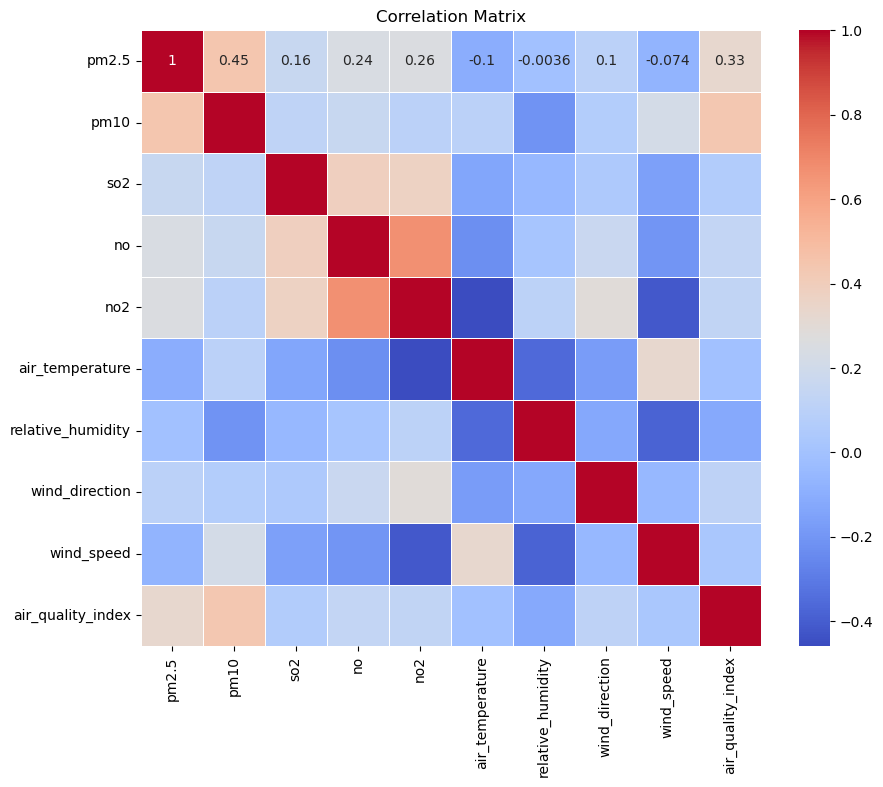

In [14]:
# Correlation heatmap
datacorr=data[['pm2.5', 'pm10', 'so2','no', 'no2', 'air_temperature', 'relative_humidity','wind_direction', 'wind_speed','air_quality_index']]

correlation_matrix = datacorr.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

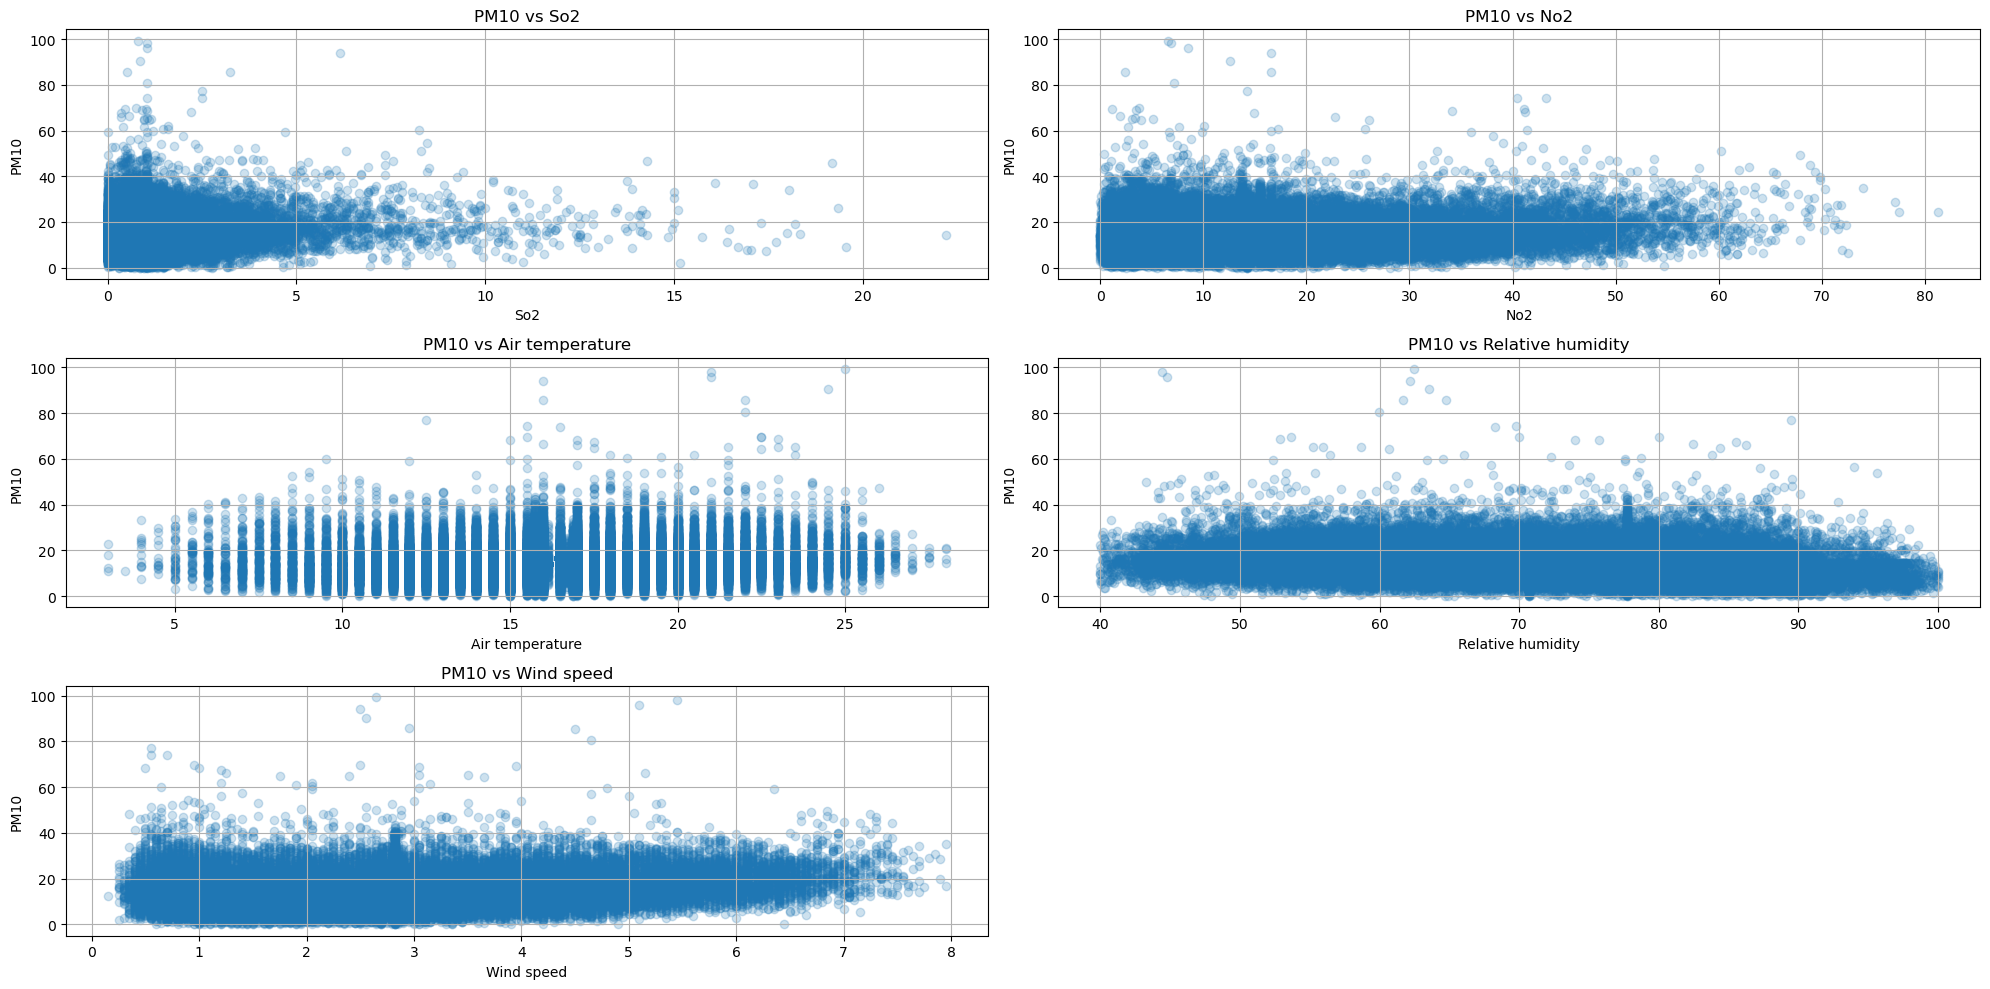

In [15]:
# List of selected attributes
attributes_list = ["so2", "no2", "air_temperature", "relative_humidity", "wind_speed"]

# Extract the relevant columns from the dataset
attributes = data[attributes_list]

# Plotting
plt.figure(figsize=(20, 10))

# Plot PM10 vs. attributes
for i, attribute in enumerate(attributes_list, start=1):
    plt.subplot(3, 2, i)
    plt.scatter(data[attribute], data['pm10'], alpha=0.22)
    plt.title(f'PM10 vs {attribute.replace("_", " ").capitalize()}')
    plt.xlabel(attribute.replace("_", " ").capitalize())
    plt.ylabel('PM10')
    plt.grid(True)

plt.tight_layout()
plt.show()


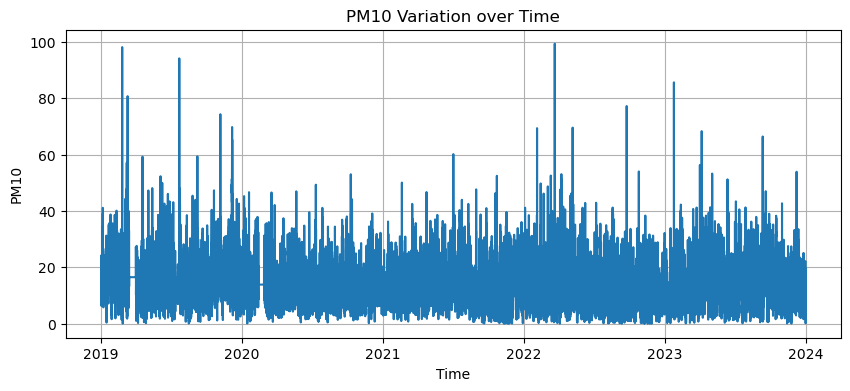

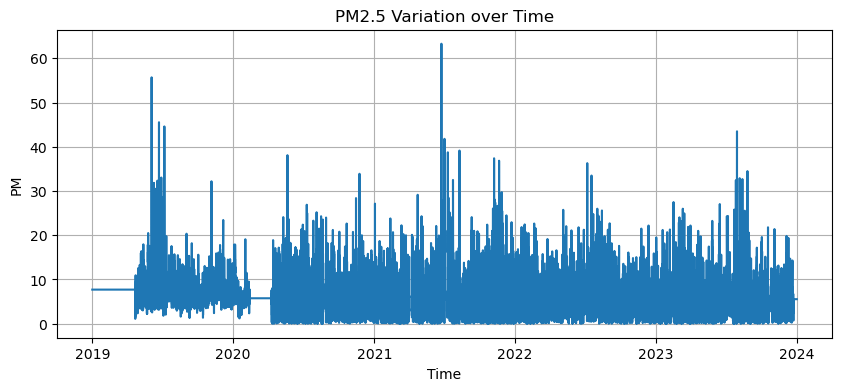

In [16]:
#PM10 Variation over Time
plt.figure(figsize=(10, 4))
sns.lineplot(x='start_time', y=data['pm10'], data=data)
plt.title('PM10 Variation over Time')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.grid(True)
plt.show()

#PM2.5 Variation over Time
plt.figure(figsize=(10, 4))
sns.lineplot(x='start_time', y=data['pm2.5'], data=data)
plt.title('PM2.5 Variation over Time')
plt.xlabel('Time')
plt.ylabel('PM')
plt.grid(True)
plt.show()



In [17]:
data['pm10'].describe()

count    43824.000000
mean        14.539756
std          7.216632
min          0.000000
25%          9.550000
50%         13.900000
75%         18.250000
max         99.300000
Name: pm10, dtype: float64

In [18]:
#Statistical summary of the selected attributes
attributes.describe()

,so2,no2,air_temperature,relative_humidity,wind_speed
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,1.105006,14.704080,16.382703,71.535659,2.806781
std,1.239947,11.853459,3.745047,12.047578,1.487789
min,0.000000,0.000000,3.000000,40.000000,0.150000
25%,0.500000,5.400000,14.000000,63.000000,1.650000
50%,0.890660,13.250000,16.000000,72.025000,2.694123
75%,1.200000,19.700000,19.000000,80.400000,3.750000
max,22.200000,81.300000,28.000000,100.000000,7.950000


In [19]:
# Drop the unwanted columns
# data = data.drop(columns=['end_time','pm2.5','air_quality_index', 'no', 'wind_direction'])

# # Create lag1 and lag2 for PM2.5
# data['PM2.5_lag1'] = data['pm2.5'].shift(1)
# data['PM2.5_lag2'] = data['pm2.5'].shift(2)

# # Create lag1 and lag2 for PM10
# data['PM10_lag1'] = data['pm10'].shift(1)
# data['PM10_lag2'] = data['pm10'].shift(2)

# Display the updated dataset
data.head(10)

,start_time,end_time,pm2.5,pm10,so2,no,no2,air_temperature,relative_humidity,wind_direction,wind_speed,air_quality_index
0,2019-01-01 00:00:00,2019-01-01 01:00:00,7.710585,16.20,1.03176,11.011144,16.520366,20.0,78.10,219.0,3.05,30.0
1,2019-01-01 01:00:00,2019-01-01 02:00:00,7.710585,18.95,1.03176,11.011144,16.520366,19.5,78.95,217.0,2.80,31.0
2,2019-01-01 02:00:00,2019-01-01 03:00:00,7.710585,24.20,1.03176,11.011144,5.300000,19.0,79.85,219.0,2.45,33.0
3,2019-01-01 03:00:00,2019-01-01 04:00:00,7.710585,22.80,1.03176,11.011144,4.650000,19.5,79.90,219.5,2.30,33.0
4,2019-01-01 04:00:00,2019-01-01 05:00:00,7.710585,19.70,1.03176,11.011144,4.150000,20.0,78.90,218.5,2.70,35.0
5,2019-01-01 05:00:00,2019-01-01 06:00:00,7.710585,17.50,1.03176,11.011144,4.200000,19.5,78.75,218.0,2.75,35.0
6,2019-01-01 06:00:00,2019-01-01 07:00:00,7.710585,15.30,1.03176,11.011144,5.000000,19.5,77.90,216.5,2.70,36.0
7,2019-01-01 07:00:00,2019-01-01 08:00:00,7.710585,15.15,1.03176,11.011144,4.600000,20.5,74.20,215.5,3.15,36.0
8,2019-01-01 08:00:00,2019-01-01 09:00:00,7.710585,16.15,1.03176,11.011144,4.200000,21.0,71.50,217.0,3.55,37.0
9,2019-01-01 09:00:00,2019-01-01 10:00:00,7.710585,15.35,1.03176,11.011144,4.450000,21.0,70.50,216.5,3.75,37.0


In [20]:


# # Create lag1 and lag2 for PM10
data['PM10_lag1'] = data['pm10'].shift(1)
data['PM10_lag2'] = data['pm10'].shift(2)
data.fillna(data.mean(), inplace=True)
data.head()


,start_time,end_time,pm2.5,pm10,so2,no,no2,air_temperature,relative_humidity,wind_direction,wind_speed,air_quality_index,PM10_lag1,PM10_lag2
0,2019-01-01 00:00:00,2019-01-01 01:00:00,7.710585,16.20,1.03176,11.011144,16.520366,20.0,78.10,219.0,3.05,30.0,14.539939,14.540248
1,2019-01-01 01:00:00,2019-01-01 02:00:00,7.710585,18.95,1.03176,11.011144,16.520366,19.5,78.95,217.0,2.80,31.0,16.200000,14.540248
2,2019-01-01 02:00:00,2019-01-01 03:00:00,7.710585,24.20,1.03176,11.011144,5.300000,19.0,79.85,219.0,2.45,33.0,18.950000,16.200000
3,2019-01-01 03:00:00,2019-01-01 04:00:00,7.710585,22.80,1.03176,11.011144,4.650000,19.5,79.90,219.5,2.30,33.0,24.200000,18.950000
4,2019-01-01 04:00:00,2019-01-01 05:00:00,7.710585,19.70,1.03176,11.011144,4.150000,20.0,78.90,218.5,2.70,35.0,22.800000,24.200000


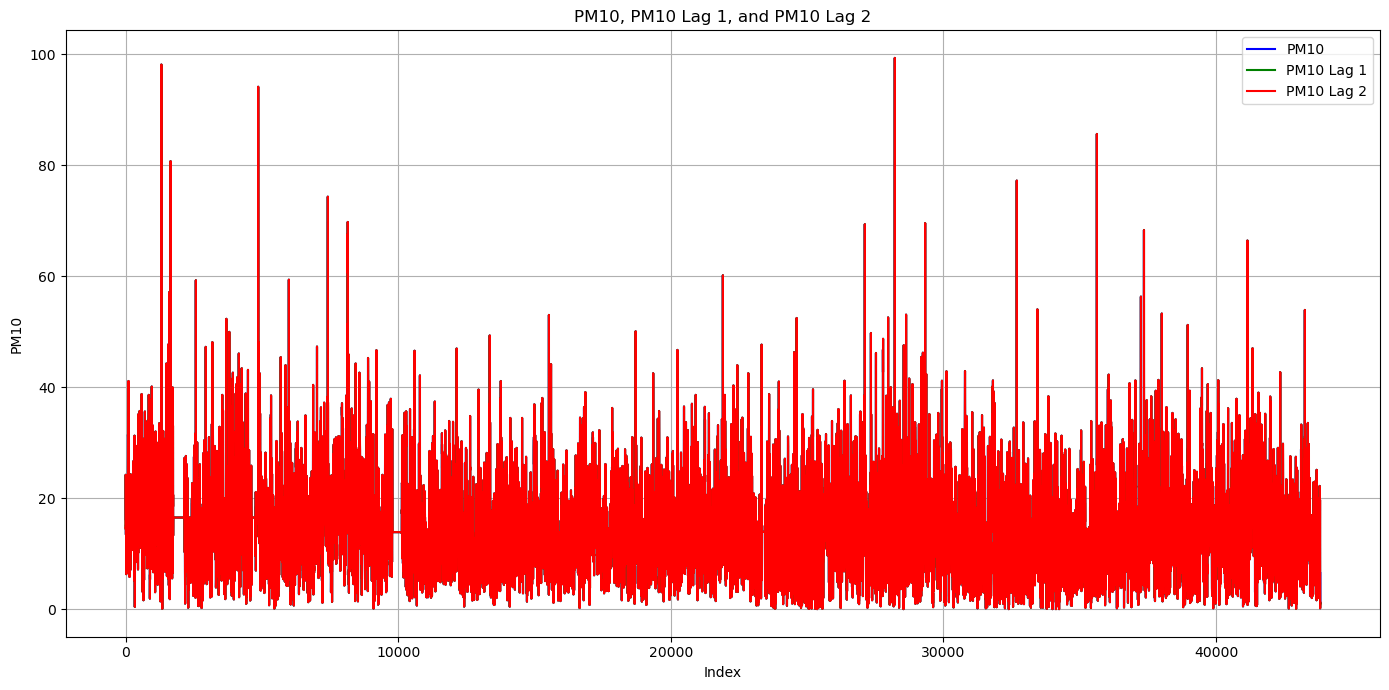

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is already defined and contains the necessary columns
# Create lag1 and lag2 for PM10
data['PM10_lag1'] = data['pm10'].shift(1)
data['PM10_lag2'] = data['pm10'].shift(2)

# Fill missing values
data.fillna(data.mean(), inplace=True)


In [48]:
#correct code 2b

Learning Rate: 0.0001 - MAE: 0.70 - MSE: 0.87 - RMSE: 0.93 - R²: 0.12
Learning Rate: 0.0010 - MAE: 0.69 - MSE: 0.84 - RMSE: 0.92 - R²: 0.15
Learning Rate: 0.0100 - MAE: 0.69 - MSE: 0.84 - RMSE: 0.92 - R²: 0.14
Learning Rate: 0.1000 - MAE: 0.73 - MSE: 0.90 - RMSE: 0.95 - R²: 0.09
Learning Rate: 1.0000 - MAE: 0.76 - MSE: 0.99 - RMSE: 1.00 - R²: -0.01
----------------------
Best Learning Rate: 0.0100
Best MAE: 0.69
Best MSE: 0.84
Best RMSE: 0.92
Best R²: 0.14


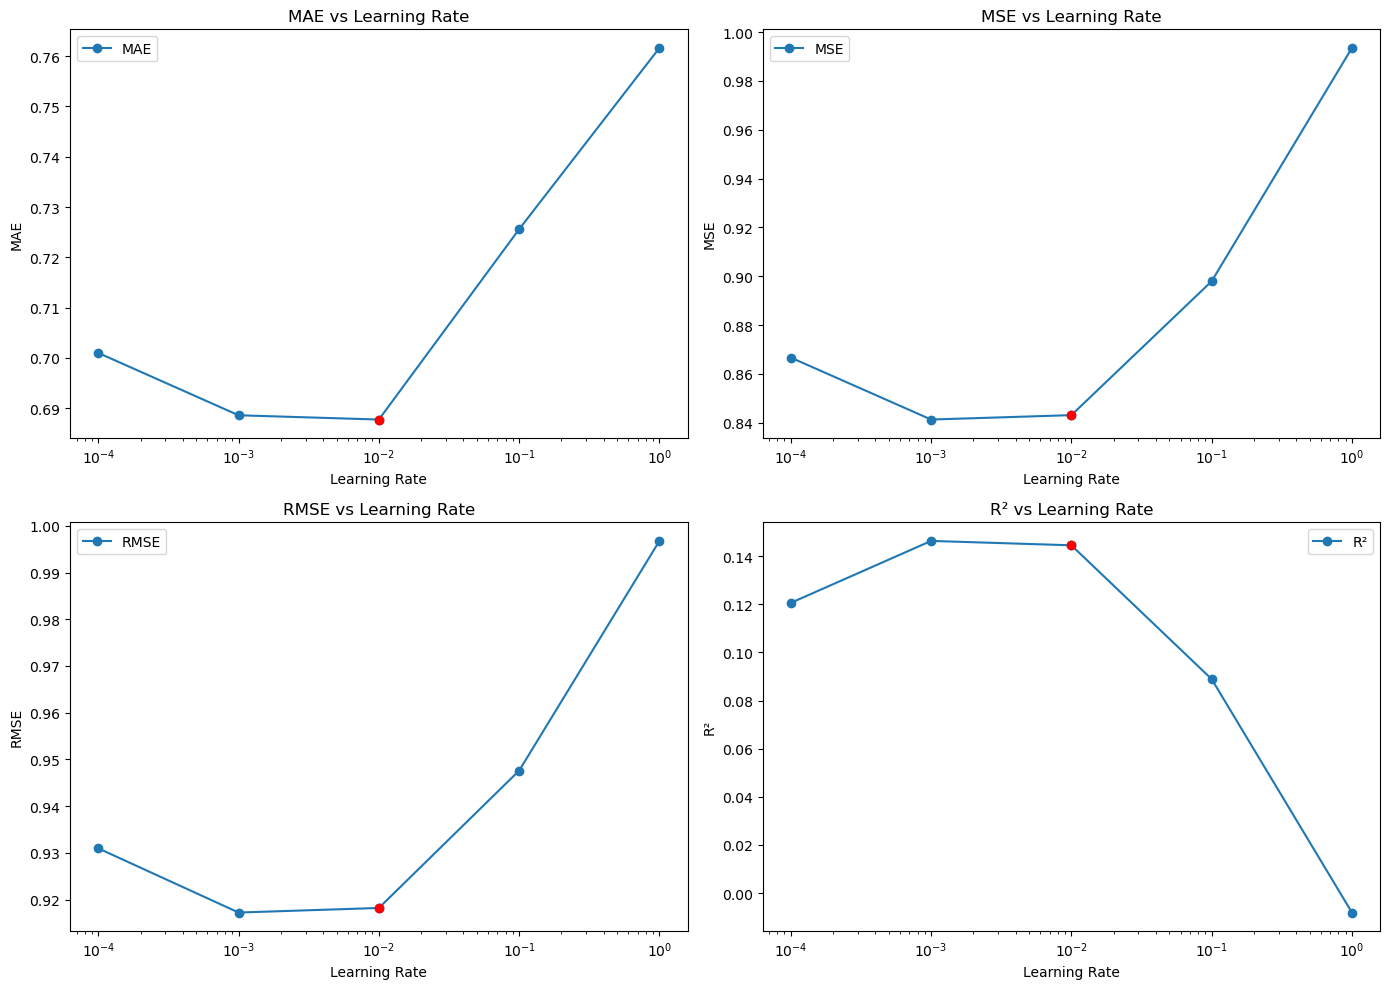

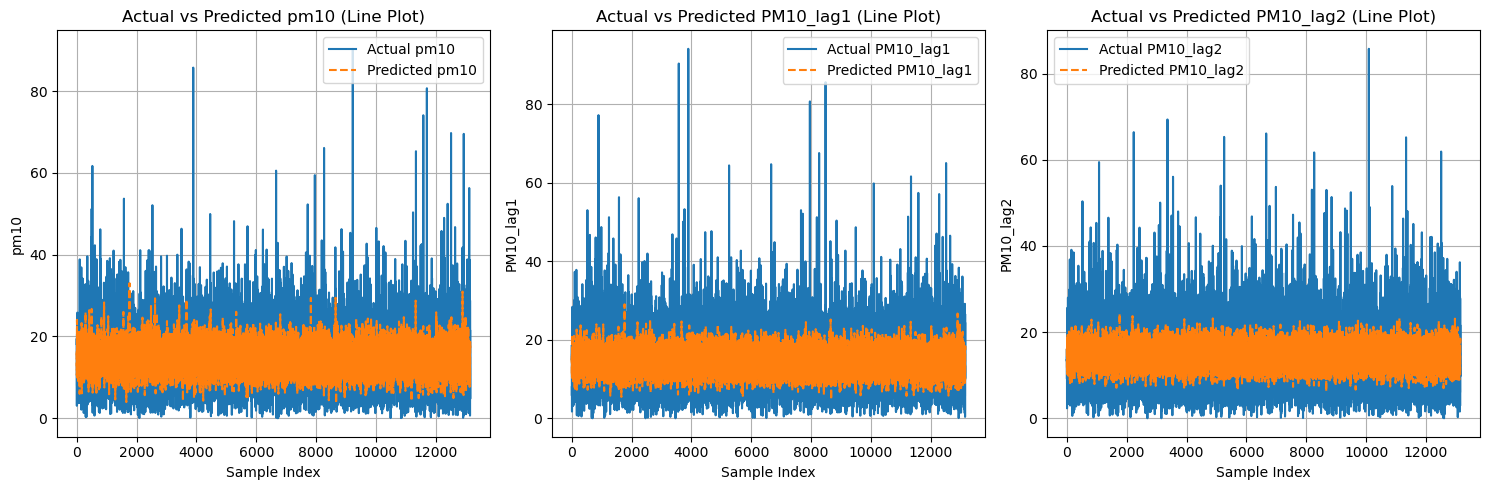

In [47]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is already defined and contains the necessary columns
X = data[['so2', 'no2', 'air_temperature', 'relative_humidity', 'wind_speed']]
y = data[['pm10', 'PM10_lag1', 'PM10_lag2']]

sc_X = StandardScaler()
sc_y = StandardScaler()

X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

# Define learning rates to experiment with
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

# Prepare lists to store results
results = []

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Function to train and evaluate the model
def evaluate_mlp(learning_rate, epochs=2000):
    mlp = MLPRegressor(
        hidden_layer_sizes=(25,),  # Single hidden layer with 25 neurons
        learning_rate_init=learning_rate,
        max_iter=epochs,
        random_state=None  # Remove random state to ensure randomness in initialization
    )
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return learning_rate, mae, mse, rmse, r2, y_pred

# Iterate over learning rates and evaluate the model
results = []
for lr in learning_rates:
    lr, mae, mse, rmse, r2, y_pred = evaluate_mlp(lr)
    results.append((lr, mae, mse, rmse, r2, y_pred))
    print(f"Learning Rate: {lr:.4f} - MAE: {mae:.2f} - MSE: {mse:.2f} - RMSE: {rmse:.2f} - R²: {r2:.2f}")

# Find the best learning rate
best_result = min(results, key=lambda x: x[1])  # Using MAE as the criterion
best_learning_rate, best_mae, best_mse, best_rmse, best_r2, best_y_pred = best_result

print('----------------------')
print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best MAE: {best_mae:.2f}')
print(f'Best MSE: {best_mse:.2f}')
print(f'Best RMSE: {best_rmse:.2f}')
print(f'Best R²: {best_r2:.2f}')

# Plotting the results
learning_rates = [result[0] for result in results]
maes = [result[1] for result in results]
mses = [result[2] for result in results]
rmses = [result[3] for result in results]
r2s = [result[4] for result in results]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(learning_rates, maes, marker='o', label='MAE')
plt.scatter([best_learning_rate], [best_mae], color='red', zorder=5)
plt.xscale('log')
plt.title('MAE vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(learning_rates, mses, marker='o', label='MSE')
plt.scatter([best_learning_rate], [best_mse], color='red', zorder=5)
plt.xscale('log')
plt.title('MSE vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(learning_rates, rmses, marker='o', label='RMSE')
plt.scatter([best_learning_rate], [best_rmse], color='red', zorder=5)
plt.xscale('log')
plt.title('RMSE vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(learning_rates, r2s, marker='o', label='R²')
plt.scatter([best_learning_rate], [best_r2], color='red', zorder=5)
plt.xscale('log')
plt.title('R² vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

# Inverse transform the scaled data
y_test_inv = sc_y.inverse_transform(y_test)
best_y_pred_inv = sc_y.inverse_transform(best_y_pred)

# Plotting Actual vs Predicted values for each PM10 predictor (line plot)
plt.figure(figsize=(15, 5))
for i, label in enumerate(['pm10', 'PM10_lag1', 'PM10_lag2']):
    plt.subplot(1, 3, i + 1)
    plt.plot(y_test_inv[:, i], label=f'Actual {label}')
    plt.plot(best_y_pred_inv[:, i], label=f'Predicted {label}', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel(label)
    plt.title(f'Actual vs Predicted {label} (Line Plot)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [1]:
#2c

Neurons in Layer 1: 1, Neurons in Layer 2: 24 - R²: 0.10 - MAE: 0.72 - RMSE: 0.97
Neurons in Layer 1: 2, Neurons in Layer 2: 23 - R²: 0.13 - MAE: 0.71 - RMSE: 0.95
Neurons in Layer 1: 3, Neurons in Layer 2: 22 - R²: 0.13 - MAE: 0.71 - RMSE: 0.95
Neurons in Layer 1: 4, Neurons in Layer 2: 21 - R²: 0.14 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 5, Neurons in Layer 2: 20 - R²: 0.14 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 6, Neurons in Layer 2: 19 - R²: 0.15 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 7, Neurons in Layer 2: 18 - R²: 0.15 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 8, Neurons in Layer 2: 17 - R²: 0.15 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 9, Neurons in Layer 2: 16 - R²: 0.15 - MAE: 0.70 - RMSE: 0.94
Neurons in Layer 1: 10, Neurons in Layer 2: 15 - R²: 0.16 - MAE: 0.70 - RMSE: 0.93
Neurons in Layer 1: 11, Neurons in Layer 2: 14 - R²: 0.16 - MAE: 0.69 - RMSE: 0.93
Neurons in Layer 1: 12, Neurons in Layer 2: 13 - R²: 0.16 - MAE: 0.70 - RMSE: 0.93
Neurons in La

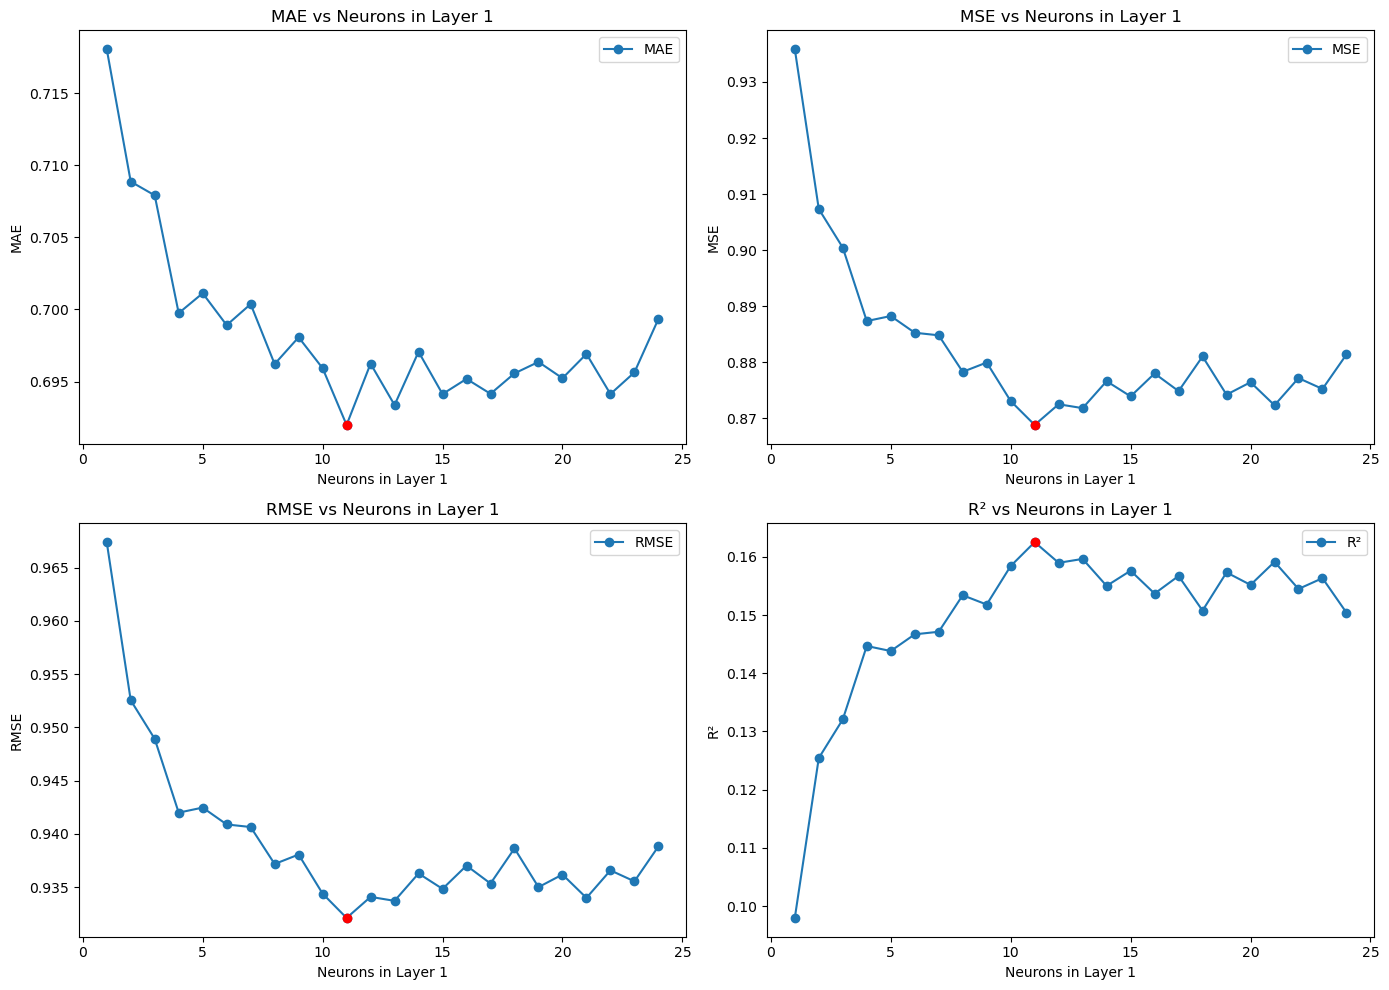

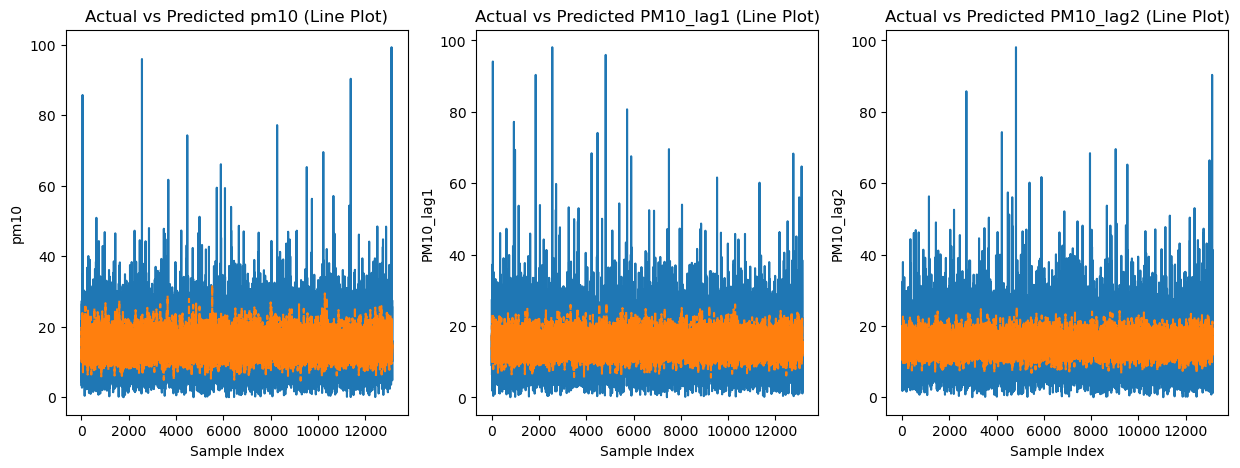

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'data' is already defined and contains the necessary columns
# Create lag1 and lag2 for PM10
data['PM10_lag1'] = data['pm10'].shift(1)
data['PM10_lag2'] = data['pm10'].shift(2)
data.fillna(data.mean(), inplace=True)

# Prepare the data
X = data[['so2', 'no2', 'air_temperature', 'relative_humidity', 'wind_speed']]
y = data[['pm10', 'PM10_lag1', 'PM10_lag2']]

# Standardize the features
sc_X = StandardScaler()
sc_y = StandardScaler()

X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

# Define total number of neurons
k = 25  # Total neurons across both hidden layers

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

best_config = None
results = []

# Iterate over possible splits between two layers
for k1 in range(1, k):  # Iterate over neurons in the first layer
    k2 = k - k1  # Remaining neurons go to the second layer
    
    # Initialize MLPRegressor
    mlp = MLPRegressor(
        hidden_layer_sizes=(k1, k2),
        max_iter=2000,
        random_state=None
    )
    
    # Train the model
    mlp.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = mlp.predict(X_test)
    
    # Evaluate performance using R² score, MAE, and RMSE
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results.append((k1, k2, mae, mse, rmse, r2))
    print(f'Neurons in Layer 1: {k1}, Neurons in Layer 2: {k2} - R²: {r2:.2f} - MAE: {mae:.2f} - RMSE: {rmse:.2f}')

# Find the best configuration
best_result = max(results, key=lambda x: x[5])  # Using R² as the criterion
best_k1, best_k2, best_mae, best_mse, best_rmse, best_r2 = best_result

print('----------------------')
print(f'Best Configuration - Neurons in Layer 1: {best_k1}, Neurons in Layer 2: {best_k2}')
print(f'Best Performance - MAE: {best_mae:.2f}, RMSE: {best_rmse:.2f}, R²: {best_r2:.2f}')

# Plotting the results
k1_values = [result[0] for result in results]
maes = [result[2] for result in results]
mses = [result[3] for result in results]
rmses = [result[4] for result in results]
r2s = [result[5] for result in results]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(k1_values, maes, marker='o', label='MAE')
plt.scatter([best_k1], [best_mae], color='red', zorder=5)
plt.title('MAE vs Neurons in Layer 1')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(k1_values, mses, marker='o', label='MSE')
plt.scatter([best_k1], [best_mse], color='red', zorder=5)
plt.title('MSE vs Neurons in Layer 1')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(k1_values, rmses, marker='o', label='RMSE')
plt.scatter([best_k1], [best_rmse], color='red', zorder=5)
plt.title('RMSE vs Neurons in Layer 1')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(k1_values, r2s, marker='o', label='R²')
plt.scatter([best_k1], [best_r2], color='red', zorder=5)
plt.title('R² vs Neurons in Layer 1')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

# Now use the best configuration to plot actual vs predicted
mlp_best = MLPRegressor(hidden_layer_sizes=(best_k1, best_k2), max_iter=2000, random_state=None)
mlp_best.fit(X_train, y_train)
best_y_pred = mlp_best.predict(X_test)

# Inverse transform the scaled data
y_test_inv = sc_y.inverse_transform(y_test)
best_y_pred_inv = sc_y.inverse_transform(best_y_pred)

# Plotting Actual vs Predicted values for each PM10 predictor (line plot)
plt.figure(figsize=(15, 5))
for i, label in enumerate(['pm10', 'PM10_lag1', 'PM10_lag2']):
    plt.subplot(1, 3, i + 1)
    plt.plot(y_test_inv[:, i], label=f'Actual {label}')
    plt.plot(best_y_pred_inv[:, i], label=f'Predicted {label}', linestyle='--')
    plt.xlabel('Sample Index')
    plt.ylabel(label)
    plt.title(f'Actual vs Predicted {label} (Line Plot)')


In [ ]:
#lstm 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import time

# Assuming 'data' is already loaded as a DataFrame
# Replace 'data' with your actual DataFrame

# Step 1: Data cleaning and preprocessing
# Select relevant columns from the dataset
dataset = data[['pm10', 'so2', 'no2', 'air_temperature', 'relative_humidity', 'wind_speed']]
dataset.columns = ['PM10', 'SO2', 'NO2', 'Temp', 'Humidity', 'Wind_Speed']

# Step 2: Normalizing data
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset.values)

# Step 3: Creating a window for previous data
# Convert the time series data to a supervised learning problem
def to_supervised(data, window_size=100):
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        Y.append(data[i, 0])  # PM10 is the target variable
    return np.array(X), np.array(Y)

X, Y = to_supervised(scaled_dataset)

# Step 4: Splitting the dataset into training and testing sets
# 70% train, 30% test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Step 5: Variables to store results
# Initialize lists to store RMSE and R-Squared for each run
rmse_list = []
r_squared_list = []

# Step 6: Run the model 30 times
for i in range(30):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Training the model
    epochs = 3
    batch_size = 30
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0)

    # Step 7: Predicting using the test data
    Y_pred = model.predict(X_test)

    # Step 8: Inverse scaling to original scale
    Y_test_scaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
    Y_pred_scaled = scaler.inverse_transform(np.concatenate((Y_pred, np.zeros((Y_pred.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

    # Step 9: Calculate RMSE
    rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_scaled))
    rmse_list.append(rmse)

    # Step 10: Calculate R-Squared
    correlation_matrix = np.corrcoef(
        np.reshape(Y_test_scaled, Y_test_scaled.shape[0]),
        np.reshape(Y_pred_scaled, Y_pred_scaled.shape[0])
    )
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2
    r_squared_list.append(r_squared)

    # Print the results for the current iteration
    print(f'Iteration {i+1} - RMSE: {rmse}, R-Squared: {r_squared}')

# Step 11: Summary statistics
# Calculate and print summary statistics for RMSE and R-Squared
rmse_mean = np.mean(rmse_list)
rmse_std = np.std(rmse_list)
r_squared_mean = np.mean(r_squared_list)
r_squared_std = np.std(r_squared_list)

print(f'RMSE - Mean: {rmse_mean}, Std Dev: {rmse_std}')
print(f'R-Squared - Mean: {r_squared_mean}, Std Dev: {r_squared_std}')

# Step 12: Plotting the results of the last run
# Plot actual vs predicted PM10 values
plt.figure(figsize=(10, 6))
plt.plot(Y_test_scaled, color='blue', label='Actual PM10')
plt.plot(Y_pred_scaled, color='green', label='Predicted PM10')
plt.title('PM10 Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

# Step 13: Plotting training and validation loss of the last run
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 14: Summary statistics dictionary
summary_stats = {
    'RMSE': {
        'Mean': rmse_mean,
        'Std Dev': rmse_std,
        'Min': np.min(rmse_list),
        'Max': np.max(rmse_list)
    },
    'R-Squared': {
        'Mean': r_squared_mean,
        'Std Dev': r_squared_std,
        'Min': np.min(r_squared_list),
        'Max': np.max(r_squared_list)
    }
}

# Print the summary statistics
print("Summary Statistics:", summary_stats)


In [ ]:
#lstm 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
import time


# Step 1: Data cleaning and preprocessing
# Select relevant columns from the dataset
dataset = data[['pm10', 'so2', 'no2', 'air_temperature', 'relative_humidity', 'wind_speed']]
dataset.columns = ['PM10', 'SO2', 'NO2', 'Temp', 'Humidity', 'Wind_Speed']

# Step 2: Normalizing data
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset.values)

# Step 3: Creating a window for previous data
# Convert the time series data to a supervised learning problem
def to_supervised(data, window_size=100):
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        Y.append(data[i, 0])  # PM10 is the target variable
    return np.array(X), np.array(Y)

X, Y = to_supervised(scaled_dataset)

# Step 4: Splitting the dataset into training and testing sets
# 70% train, 30% test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# List of batch sizes to investigate
batch_sizes = [10, 20, 30, 40, 50]

# Variables to store results for each batch size
results = {}

# Step 5: Run the model for each batch size
for batch_size in batch_sizes:
    rmse_list = []
    r_squared_list = []
    runtime_list = []
    
    for i in range(30):
        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(units=100, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=100, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=100))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        # Compile the model with a constant learning rate of 0.01
        optimizer = Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Measure the time taken for training
        start_time = time.time()
        
        # Training the model
        epochs = 3
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Step 6: Predicting using the test data
        Y_pred = model.predict(X_test)

        # Step 7: Inverse scaling to original scale
        Y_test_scaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
        Y_pred_scaled = scaler.inverse_transform(np.concatenate((Y_pred, np.zeros((Y_pred.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

        # Step 8: Calculate RMSE
        rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_scaled))
        rmse_list.append(rmse)

        # Step 9: Calculate R-Squared
        correlation_matrix = np.corrcoef(
            np.reshape(Y_test_scaled, Y_test_scaled.shape[0]),
            np.reshape(Y_pred_scaled, Y_pred_scaled.shape[0])
        )
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy ** 2
        r_squared_list.append(r_squared)
    
    # Store the results for the current batch size
    results[batch_size] = {
        'RMSE': {
            'Mean': np.mean(rmse_list),
            'Std Dev': np.std(rmse_list),
            'Min': np.min(rmse_list),
            'Max': np.max(rmse_list)
        },
        'R-Squared': {
            'Mean': np.mean(r_squared_list),
            'Std Dev': np.std(r_squared_list),
            'Min': np.min(r_squared_list),
            'Max': np.max(r_squared_list)
        },
        'Runtime': {
            'Mean': np.mean(runtime_list),
            'Std Dev': np.std(runtime_list),
            'Min': np.min(runtime_list),
            'Max': np.max(runtime_list)
        }
    }

    # Print the summary statistics for the current batch size
    print(f'Batch Size: {batch_size}')
    print(f"RMSE - Mean: {results[batch_size]['RMSE']['Mean']}, Std Dev: {results[batch_size]['RMSE']['Std Dev']}, Min: {results[batch_size]['RMSE']['Min']}, Max: {results[batch_size]['RMSE']['Max']}")
    print(f"R-Squared - Mean: {results[batch_size]['R-Squared']['Mean']}, Std Dev: {results[batch_size]['R-Squared']['Std Dev']}, Min: {results[batch_size]['R-Squared']['Min']}, Max: {results[batch_size]['R-Squared']['Max']}")
    print(f"Runtime - Mean: {results[batch_size]['Runtime']['Mean']}s, Std Dev: {results[batch_size]['Runtime']['Std Dev']}s, Min: {results[batch_size]['Runtime']['Min']}s, Max: {results[batch_size]['Runtime']['Max']}s")
    print("\n")

# Choose the best batch size based on the results
best_batch_size = None
best_rmse_mean = float('inf')
best_runtime_mean = float('inf')

for batch_size in batch_sizes:
    if results[batch_size]['RMSE']['Mean'] < best_rmse_mean:
        best_rmse_mean = results[batch_size]['RMSE']['Mean']
        best_runtime_mean = results[batch_size]['Runtime']['Mean']
        best_batch_size = batch_size
    elif results[batch_size]['RMSE']['Mean'] == best_rmse_mean:
        if results[batch_size]['Runtime']['Mean'] < best_runtime_mean:
            best_runtime_mean = results[batch_size]['Runtime']['Mean']
            best_batch_size = batch_size

print(f'The best batch size is {best_batch_size} with RMSE Mean: {best_rmse_mean} and Runtime Mean: {best_runtime_mean}s')


In [ ]:
#lstm 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
import time

# Step 1: Data cleaning and preprocessing
# Select relevant columns from the dataset
dataset = data[['pm10', 'so2', 'no2', 'air_temperature', 'relative_humidity', 'wind_speed']]
dataset.columns = ['PM10', 'SO2', 'NO2', 'Temp', 'Humidity', 'Wind_Speed']

# Step 2: Normalizing data
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset.values)

# Step 3: Creating a window for previous data
# Convert the time series data to a supervised learning problem
def to_supervised(data, window_size=100):
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        Y.append(data[i, 0])  # PM10 is the target variable
    return np.array(X), np.array(Y)

X, Y = to_supervised(scaled_dataset)

# Step 4: Splitting the dataset into training and testing sets
# 70% train, 30% test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# List of neuron configurations to investigate
neuron_configs = [20, 50, 100, 200]

# Variables to store results for each neuron configuration
results = {}

# Step 5: Run the model for each neuron configuration
for neurons in neuron_configs:
    rmse_list = []
    r_squared_list = []
    runtime_list = []
    
    for i in range(30):
        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(units=neurons, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=neurons, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=neurons))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        # Compile the model with a constant learning rate of 0.01
        optimizer = Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Measure the time taken for training
        start_time = time.time()
        
        # Training the model
        epochs = 3
        batch_size = 30
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Step 6: Predicting using the test data
        Y_pred = model.predict(X_test)

        # Step 7: Inverse scaling to original scale
        Y_test_scaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]
        Y_pred_scaled = scaler.inverse_transform(np.concatenate((Y_pred, np.zeros((Y_pred.shape[0], dataset.shape[1]-1))), axis=1))[:, 0]

        # Step 8: Calculate RMSE
        rmse = np.sqrt(mean_squared_error(Y_test_scaled, Y_pred_scaled))
        rmse_list.append(rmse)

        # Step 9: Calculate R-Squared
        correlation_matrix = np.corrcoef(
            np.reshape(Y_test_scaled, Y_test_scaled.shape[0]),
            np.reshape(Y_pred_scaled, Y_pred_scaled.shape[0])
        )
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy ** 2
        r_squared_list.append(r_squared)
    
    # Store the results for the current neuron configuration
    results[neurons] = {
        'RMSE': {
            'Mean': np.mean(rmse_list),
            'Std Dev': np.std(rmse_list),
            'Min': np.min(rmse_list),
            'Max': np.max(rmse_list)
        },
        'R-Squared': {
            'Mean': np.mean(r_squared_list),
            'Std Dev': np.std(r_squared_list),
            'Min': np.min(r_squared_list),
            'Max': np.max(r_squared_list)
        },
        'Runtime': {
            'Mean': np.mean(runtime_list),
            'Std Dev': np.std(runtime_list),
            'Min': np.min(runtime_list),
            'Max': np.max(runtime_list)
        }
    }

    # Print the summary statistics for the current neuron configuration
    print(f'Neurons: {neurons}')
    print(f"RMSE - Mean: {results[neurons]['RMSE']['Mean']}, Std Dev: {results[neurons]['RMSE']['Std Dev']}, Min: {results[neurons]['RMSE']['Min']}, Max: {results[neurons]['RMSE']['Max']}")
    print(f"R-Squared - Mean: {results[neurons]['R-Squared']['Mean']}, Std Dev: {results[neurons]['R-Squared']['Std Dev']}, Min: {results[neurons]['R-Squared']['Min']}, Max: {results[neurons]['R-Squared']['Max']}")
    print(f"Runtime - Mean: {results[neurons]['Runtime']['Mean']}s, Std Dev: {results[neurons]['Runtime']['Std Dev']}s, Min: {results[neurons]['Runtime']['Min']}s, Max: {results[neurons]['Runtime']['Max']}s")
    print("\n")

# Choose the best neuron configuration based on the results
best_neurons = None
best_rmse_mean = float('inf')
best_runtime_mean = float('inf')

for neurons in neuron_configs:
    if results[neurons]['RMSE']['Mean'] < best_rmse_mean:
        best_rmse_mean = results[neurons]['RMSE']['Mean']
        best_runtime_mean = results[neurons]['Runtime']['Mean']
        best_neurons = neurons
    elif results[neurons]['RMSE']['Mean'] == best_rmse_mean:
        if results[neurons]['Runtime']['Mean'] < best_runtime_mean:
            best_runtime_mean = results[neurons]['Runtime']['Mean']
            best_neurons = neurons

print(f'The best number of neurons is {best_neurons} with RMSE Mean: {best_rmse_mean} and Runtime Mean: {best_runtime_mean}s')
